In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# --- Load and Prepare Data ---
file_path = "cleandata.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], format='%b-%Y')
df = df.sort_values(by='Date').set_index('Date')

target = 'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)'

# --- Feature Engineering ---
def create_features(df):
    df = df.copy()
    df['spot_rate_lag_1'] = df[target].shift(1)
    df['spot_rate_lag_2'] = df[target].shift(2)
    df['spot_rate_lag_3'] = df[target].shift(3)
    df['spot_rate_roll3'] = df[target].rolling(window=3).mean()
    df['spot_rate_roll6'] = df[target].rolling(window=6).mean()
    return df.dropna()

df = create_features(df)

# --- Forecast Setup ---
start_date = pd.Timestamp("2024-01-01")
end_date = pd.Timestamp("2024-12-01")
forecast_start_months = pd.date_range(start=start_date, end=end_date, freq='MS')

forecast_results = []

for base_month in forecast_start_months:
    # Forecast next 6 months
    forecast_window = [base_month + pd.DateOffset(months=i) for i in range(6)]
    if forecast_window[-1] > end_date:
        break  # Avoid forecasting beyond available range

    # Prepare training data
    df_features = create_features(df.copy())
    train_data = df_features[df_features.index < base_month]
    if train_data.empty:
        continue

    X_train = train_data.drop(columns=[target])
    y_train = train_data[target]

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    # Forecast only the last month in the 6-month window
    forecast_month = forecast_window[-1]
    test_data = df_features[df_features.index == forecast_month]
    if test_data.empty:
        continue

    X_test = test_data.drop(columns=[target])
    y_test = test_data[target]
    y_pred = model.predict(X_test)

    forecast_results.append({
        'Forecasted Month': forecast_month,
        'Base Forecast Month': base_month,
        'Actual Spot Rate': y_test.values[0],
        'Predicted Spot Rate': y_pred[0]
    })

# --- Results ---
forecast_df = pd.DataFrame(forecast_results).set_index('Forecasted Month')

# --- Metrics ---
mae = mean_absolute_error(forecast_df['Actual Spot Rate'], forecast_df['Predicted Spot Rate'])
rmse = np.sqrt(mean_squared_error(forecast_df['Actual Spot Rate'], forecast_df['Predicted Spot Rate']))
print(f"Clean 6-Month Rolling Forecast - MAE: ${mae:,.2f} per day")
print(f"Clean 6-Month Rolling Forecast - RMSE: ${rmse:,.2f} per day")



Clean 6-Month Rolling Forecast - MAE: $27,234.95 per day
Clean 6-Month Rolling Forecast - RMSE: $29,381.93 per day


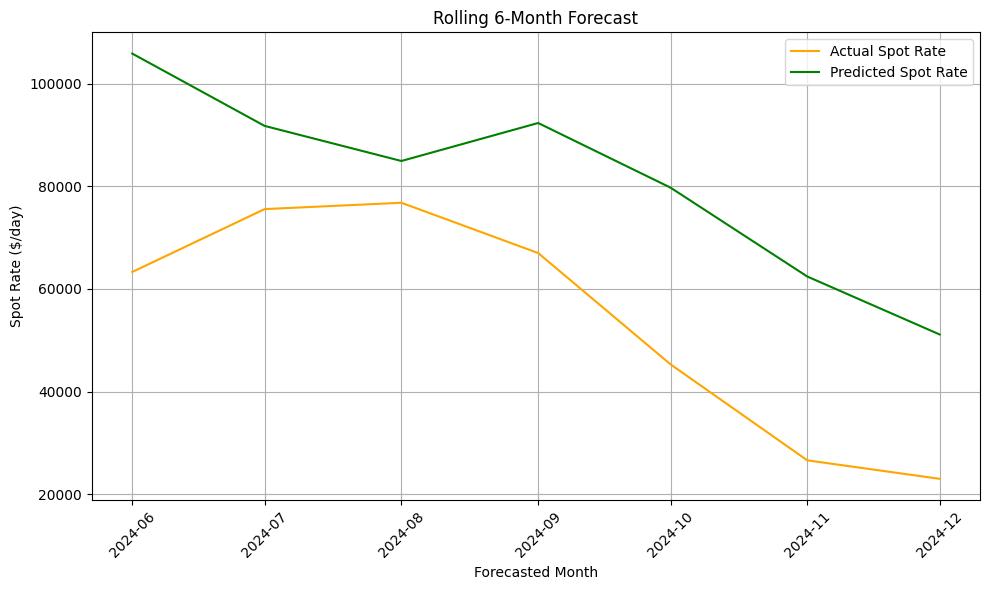

In [3]:
# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(forecast_df.index, forecast_df['Actual Spot Rate'], label='Actual Spot Rate', color='orange')
plt.plot(forecast_df.index, forecast_df['Predicted Spot Rate'], label='Predicted Spot Rate', color='green')
plt.title('Rolling 6-Month Forecast')
plt.xlabel('Forecasted Month')
plt.ylabel('Spot Rate ($/day)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
